Use ECCO to plot 200/400 m depth in deep water (2000 bathymetry) on east and west side of Greenland to see when polar water comes. Then do back of the envelope calculation to figure out when we'd expect to see it in the fjord

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import cmocean
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

In [2]:
# define root directory for location of all downloaded NetCDF files
root_dir = Path('../data/ECCO_V4r4_PODAAC')

# define the directory where the files specific to desired dataset are stored
nc_heat_dir = root_dir / "ECCO_L4_HEAT_FLUX_05DEG_MONTHLY_V4R4"
nc_temp_salt_dir = root_dir / "ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4"

In [3]:
# get all files in each folder for import
heat_nc_files = list(nc_heat_dir.glob('*nc'))
temp_salt_nc_files = list(nc_temp_salt_dir.glob('*nc'))

In [4]:
# import 26 years of ecco temperature data
temp_salt_ds = xr.open_mfdataset(temp_salt_nc_files, parallel=True, data_vars='minimal',\
                                coords='minimal', compat='override')

temp_salt_ds

<xarray.Dataset>
Dimensions:         (time: 312, Z: 50, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * time            (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T...
  * Z               (Z) float32 -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
  * latitude        (latitude) float32 -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 -179.8 -179.2 -178.8 ... 179.2 179.8
    time_bnds       (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    latitude_bnds   (latitude, nv) float32 dask.array<chunksize=(360, 2), meta=np.ndarray>
    longitude_bnds  (longitude, nv) float32 dask.array<chunksize=(720, 2), meta=np.ndarray>
    Z_bnds          (Z, nv) float32 dask.array<chunksize=(50, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    THETA           (time, Z, latitude, longitude) float32 dask.array<chunksize=(1, 50, 360, 720), meta=np.ndarray>
    SALT            (time, Z, latitude, longitude) float32 dask.array<chunksize=(1, 50, 360, 720), meta=np.ndarray>
Attributes: (12/62)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on a regular lat-lon gri...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            7e05edde-4159-11eb-9ce1-0cc47a3f47f1

In [5]:
# import the geometry data file that provides area and volume information for grid cells
geometry_ds = xr.open_dataset('../data/ECCO_V4r4_PODAAC/ECCO_L4_GEOMETRY_05DEG_V4R4/GRID_GEOMETRY_ECCO_V4r4_latlon_0p50deg.nc')
geometry_ds

<xarray.Dataset>
Dimensions:         (Z: 50, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * Z               (Z) float32 -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
  * latitude        (latitude) float32 -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 -179.8 -179.2 -178.8 ... 179.2 179.8
    latitude_bnds   (latitude, nv) float32 ...
    longitude_bnds  (longitude, nv) float32 ...
    Z_bnds          (Z, nv) float32 ...
Dimensions without coordinates: nv
Data variables:
    hFacC           (Z, latitude, longitude) float64 ...
    Depth           (latitude, longitude) float64 ...
    area            (latitude, longitude) float64 ...
    drF             (Z) float32 ...
    maskC           (Z, latitude, longitude) bool ...
Attributes: (12/57)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on a regular lat-lon gri...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    references:                      ECCO Consortium, Fukumori, I., Wang, O.,...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters for the 0.5 deg...
    uuid:                            b4795c62-86e5-11eb-9c5f-f8f21e2ee3e0

In [6]:
# pull out Depth from geometry file to use for creating the mask
ecco_depth = geometry_ds.Depth

In [7]:
# meshgrid for longitude and latitude 1D arrays
data_x_mg, data_y_mg = np.meshgrid(ecco_depth.longitude,ecco_depth.latitude)

In [26]:
# create masks for regions farther offshore (>2000 m deep) around Greenland

# SE Greenland
SE_greenland_mask = np.where(np.logical_and(ecco_depth > 2000, ecco_depth < 2500), 1, np.nan)*\
                    np.where(np.logical_and(data_y_mg > 60, data_y_mg < 63), 1, np.nan)*\
                    np.where(data_x_mg > -43, 1, np.nan)*np.where(data_x_mg < -35, 1, np.nan)

# SW Greenland
SW_greenland_mask = np.where(np.logical_and(ecco_depth > 2000, ecco_depth < 3000), 1, np.nan)*\
                    np.where(np.logical_and(data_y_mg > 60, data_y_mg < 63), 1, np.nan)*\
                    np.where(data_x_mg > -53, 1, np.nan)*np.where(data_x_mg < -50, 1, np.nan)

# central W Greenland
CW_greenland_mask = np.where(np.logical_and(ecco_depth > 100, ecco_depth < 2000), 1, np.nan)*\
                    np.where(np.logical_and(data_y_mg > 64, data_y_mg < 66), 1, np.nan)*\
                    np.where(data_x_mg > -56, 1, np.nan)*np.where(data_x_mg < -51, 1, np.nan)

# NW Greenland
NW_greenland_mask = np.where(np.logical_and(ecco_depth > 2000, ecco_depth < 3000), 1, np.nan)*\
                    np.where(np.logical_and(data_y_mg > 72, data_y_mg < 77), 1, np.nan)*\
                    np.where(data_x_mg > -65, 1, np.nan)*np.where(data_x_mg < -56, 1, np.nan)

In [27]:
# multiply ecco temp/salinity by mask to isolate data 
SE_greenland_temp_da = temp_salt_ds.THETA*SE_greenland_mask
SW_greenland_temp_da = temp_salt_ds.THETA*SW_greenland_mask
CW_greenland_temp_da = temp_salt_ds.THETA*CW_greenland_mask
NW_greenland_temp_da = temp_salt_ds.THETA*NW_greenland_mask

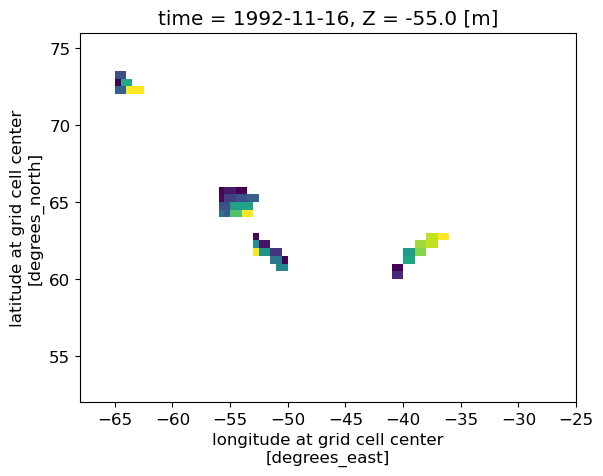

In [28]:
# sanity check plot to make sure the mask worked
SE_greenland_temp_da.isel(time=10, Z=5).plot(add_colorbar=False)
SW_greenland_temp_da.isel(time=10, Z=5).plot(add_colorbar=False)
CW_greenland_temp_da.isel(time=10, Z=5).plot(add_colorbar=False)
NW_greenland_temp_da.isel(time=10, Z=5).plot(add_colorbar=False)
plt.xlim(-68,-25)
plt.ylim(52,76);

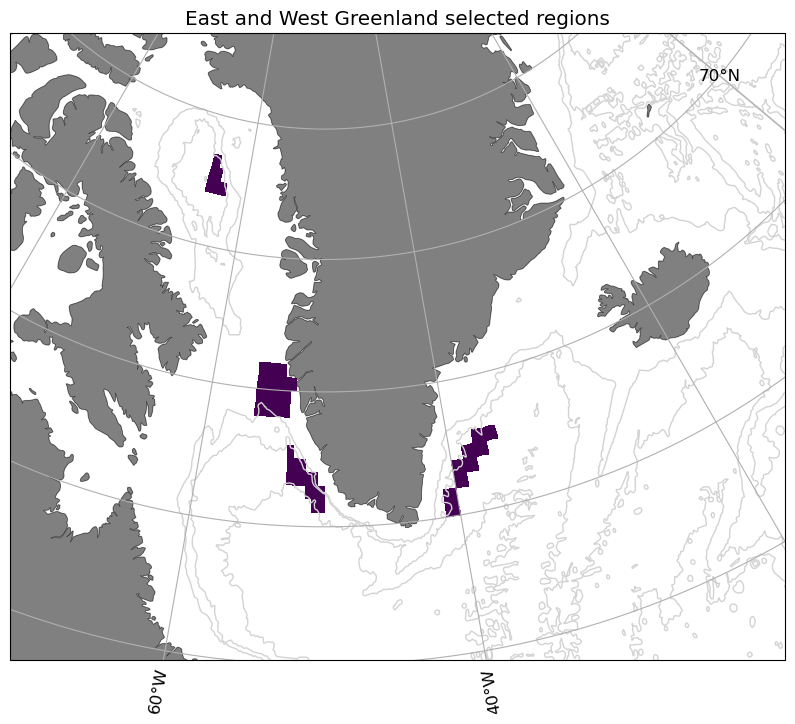

In [29]:
# Plot region selected for analysis
plt.rcParams['font.size'] = 12
fig = plt.figure(figsize=[10,10])

ax1=plt.subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude=-50))
ax1.set_extent([-70, -20, 55, 77], ccrs.PlateCarree()) # Limit the map extent
ax1.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=0.2)
ax1.add_feature(cfeature.LAND, color='gray')
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
ax1.add_feature(bathym, facecolor='none', edgecolor='lightgray')
bathym = cfeature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical')
ax1.add_feature(bathym, facecolor='none', edgecolor='lightgray')
bathym = cfeature.NaturalEarthFeature(name='bathymetry_H_3000', scale='10m', category='physical')
ax1.add_feature(bathym, facecolor='none', edgecolor='lightgray', label=True)

gl = ax1.gridlines(draw_labels=True)

gl.top_labels=False

data_cartopy_crs = ccrs.PlateCarree()
SE_greenland_temp_da.isel(time=10, Z=5).plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='viridis',vmin= 5, vmax=6,add_colorbar=False)
SW_greenland_temp_da.isel(time=10, Z=5).plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='viridis',vmin= 5, vmax=6,add_colorbar=False)
CW_greenland_temp_da.isel(time=10, Z=5).plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='viridis',vmin= 5, vmax=6,add_colorbar=False)
NW_greenland_temp_da.isel(time=10, Z=5).plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='viridis',vmin= 5, vmax=6,add_colorbar=False)
                         
ax1.set_title("East and West Greenland selected regions");

Plot timeseries of temperature and salinity at 200m

In [30]:
SE_greenland_temp200_da = SE_greenland_temp_da.sel(Z=-200, method='nearest').groupby("time.month").mean(dim=["time"])

In [31]:
# calculate the area-weighted mean
area_SE = geometry_ds.area*SE_greenland_mask
area_SE_total = area_SE.sum(['latitude','longitude'])

area_SW = geometry_ds.area*SW_greenland_mask
area_SW_total = area_SW.sum(['latitude','longitude'])

area_CW = geometry_ds.area*CW_greenland_mask
area_CW_total = area_CW.sum(['latitude','longitude'])

area_NW = geometry_ds.area*NW_greenland_mask
area_NW_total = area_NW.sum(['latitude','longitude'])

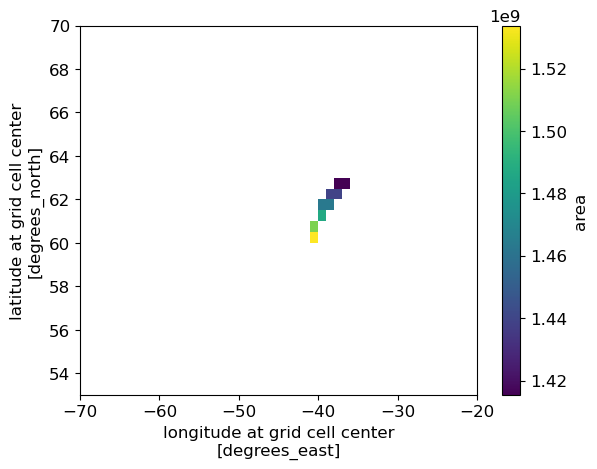

In [32]:
# sanity check plot (area decreases with increasing latitude)
area_SE.sel(longitude=slice(-70,-20),latitude=slice(53,70)).plot();

In [32]:
# temp weighted by grid-cell area
SE_temp_mean_weighted = (SE_greenland_temp_da*area_SE).sum(dim=["latitude","longitude"])/area_SE_total
SW_temp_mean_weighted = (SW_greenland_temp_da*area_SW).sum(dim=["latitude","longitude"])/area_SW_total
CW_temp_mean_weighted = (CW_greenland_temp_da*area_SW).sum(dim=["latitude","longitude"])/area_CW_total
# NW_temp_mean_weighted = (NW_greenland_temp_da*area_NW).sum(dim=["latitude","longitude"])/area_NW_total

# now get the mean for each month from 1992-2017
SE_temp_mean_month_weighted = SE_temp_mean_weighted.groupby("time.month").mean(dim=["time"])
SW_temp_mean_month_weighted = SW_temp_mean_weighted.groupby("time.month").mean(dim=["time"])
CW_temp_mean_month_weighted = CW_temp_mean_weighted.groupby("time.month").mean(dim=["time"])
# NW_temp_mean_month_weighted = NW_temp_mean_weighted.groupby("time.month").mean(dim=["time"])

In [97]:
# For comparison, calculate unweighted monthly average
SE_temp_mean_month_unweighted = SE_greenland_temp_da.groupby("time.month").mean(dim=['time','latitude','longitude'])
SW_temp_mean_month_unweighted = SW_greenland_temp_da.groupby("time.month").mean(dim=['time','latitude','longitude'])

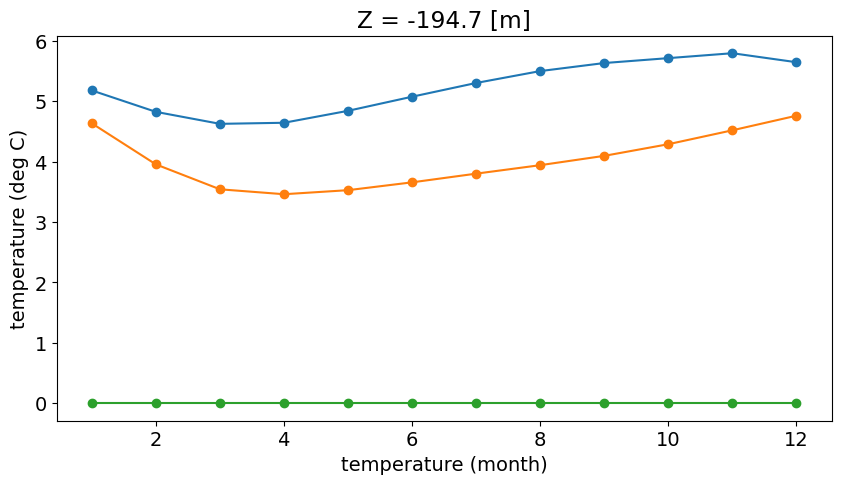

In [33]:
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['font.size'] = 14

SE_temp_mean_month_weighted.sel(Z=-200, method='nearest').plot(marker='o')
SW_temp_mean_month_weighted.sel(Z=-200, method='nearest').plot(marker='o')
CW_temp_mean_month_weighted.sel(Z=-200, method='nearest').plot(marker='o')
# NW_temp_mean_month_weighted.sel(Z=-200, method='nearest').plot(marker='o')

plt.ylabel('temperature (deg C)')
plt.xlabel('temperature (month)');

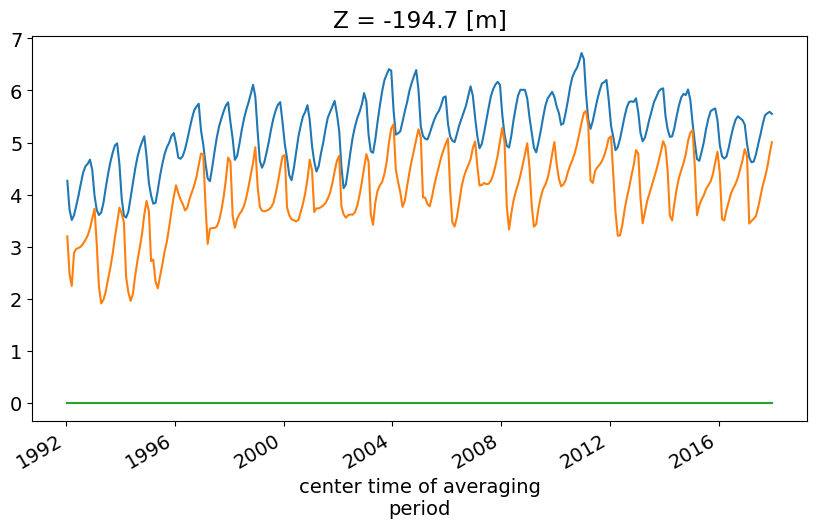

In [34]:
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['font.size'] = 14

SE_temp_mean_weighted.sel(Z=-200, method='nearest').plot()
SW_temp_mean_weighted.sel(Z=-200, method='nearest').plot()
CW_temp_mean_weighted.sel(Z=-200, method='nearest').plot()
# NW_temp_mean_weighted.sel(Z=-200, method='nearest').plot()

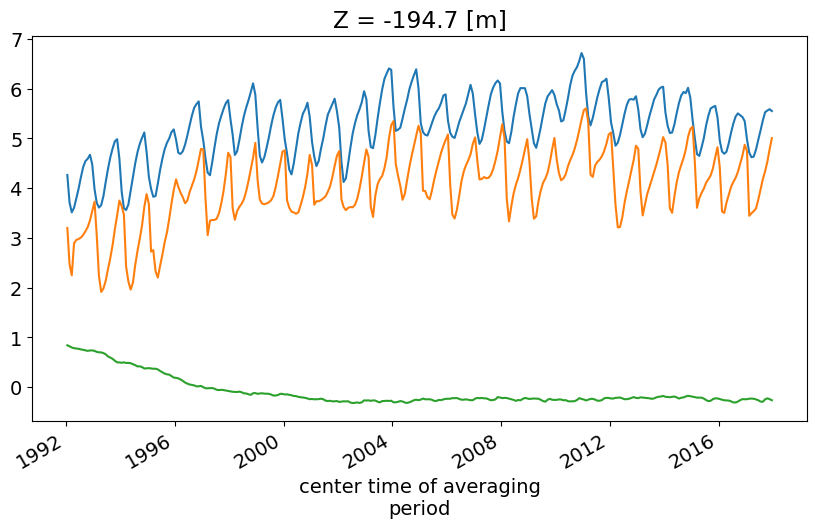

In [55]:
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['font.size'] = 14

SE_temp_mean_weighted.sel(Z=-200, method='nearest').plot()
SW_temp_mean_weighted.sel(Z=-200, method='nearest').plot()
CW_temp_mean_weighted.sel(Z=-200, method='nearest').plot()
# NW_temp_mean_weighted.sel(Z=-200, method='nearest').plot()

## Plot seasonal variability in temp and salinity at various depths

### Z= -5 meters

In [47]:
# select greenland region we are interested in
temp_salt_slice_ds = temp_salt_ds.sel(latitude=slice(59,82), longitude=slice(-84.25,-32.75)).sel(Z=-5,method='nearest')

# get monthly anomaly for temp and salinity
temp_month_slice_ds = temp_salt_slice_ds.groupby("time.month").mean("time").THETA - temp_salt_slice_ds.THETA.mean()
salt_month_slice_ds = temp_salt_slice_ds.groupby("time.month").mean("time").SALT - temp_salt_slice_ds.SALT.mean()

print(temp_salt_slice_ds.THETA.mean().values)
print(temp_salt_slice_ds.SALT.mean().values)

0.8585555
32.466515


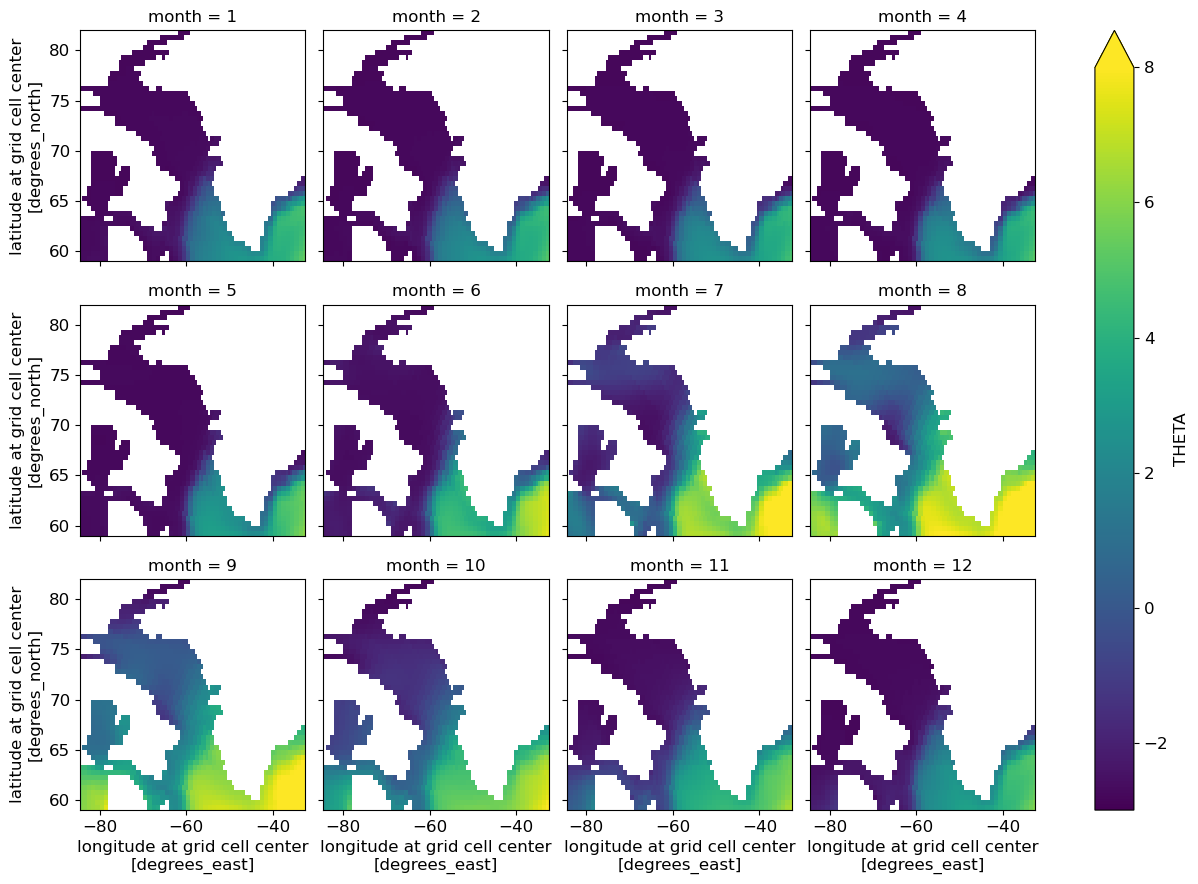

In [54]:
plt.rcParams['font.size'] = 12
temp_month_slice_ds.plot(x="longitude",y="latitude",vmin=-3,vmax=8,col="month",col_wrap=4)

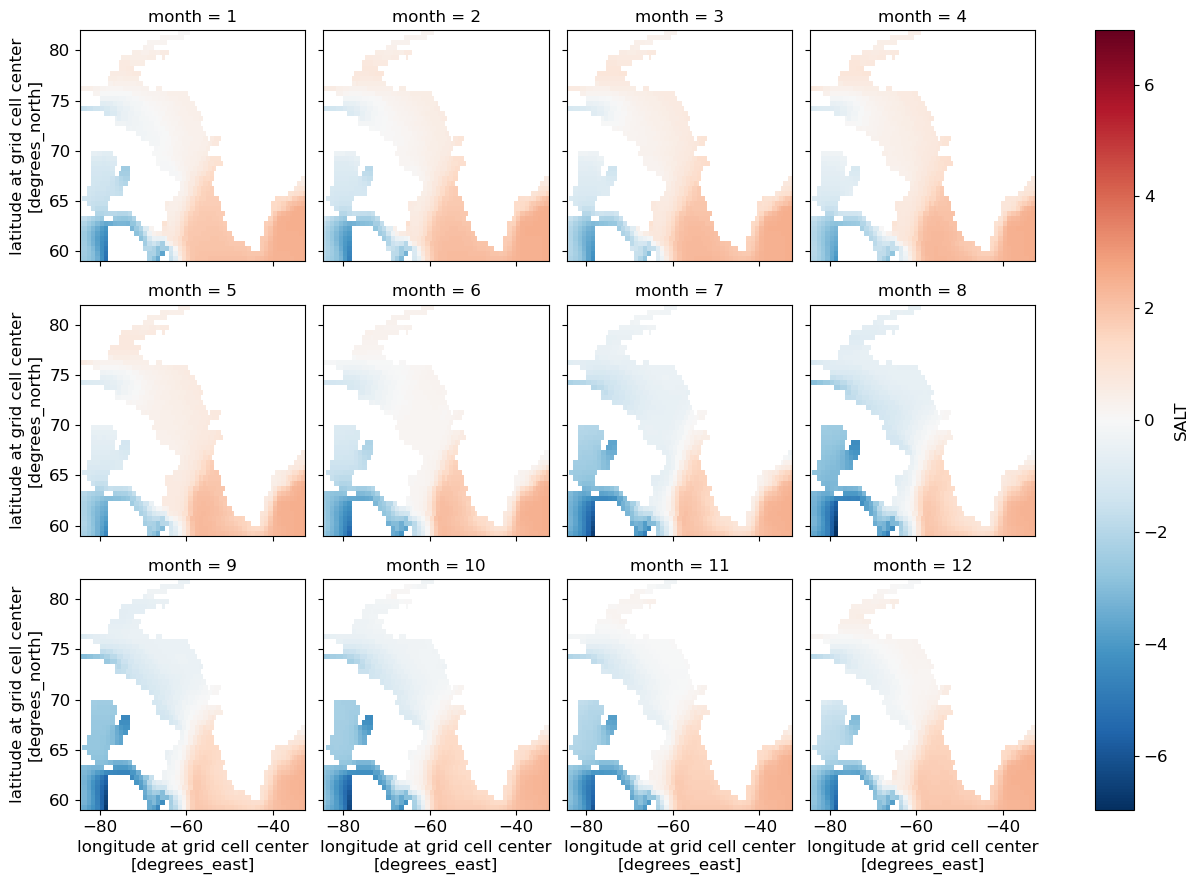

In [49]:
plt.rcParams['font.size'] = 12
salt_month_slice_ds.plot(x="longitude",y="latitude",col="month",col_wrap=4)

### Z= -200 meters

In [46]:
# select greenland region we are interested in
temp_salt_slice_ds = temp_salt_ds.sel(latitude=slice(59,82), longitude=slice(-84.25,-32.75)).sel(Z=-200,method='nearest')

# get monthly anomaly for temp and salinity
temp_month_slice_ds = temp_salt_slice_ds.groupby("time.month").mean("time").THETA - temp_salt_slice_ds.THETA.mean()
salt_month_slice_ds = temp_salt_slice_ds.groupby("time.month").mean("time").SALT - temp_salt_slice_ds.SALT.mean()

print(temp_salt_slice_ds.THETA.mean().values)
print(temp_salt_slice_ds.SALT.mean().values)

1.4956323
34.273605


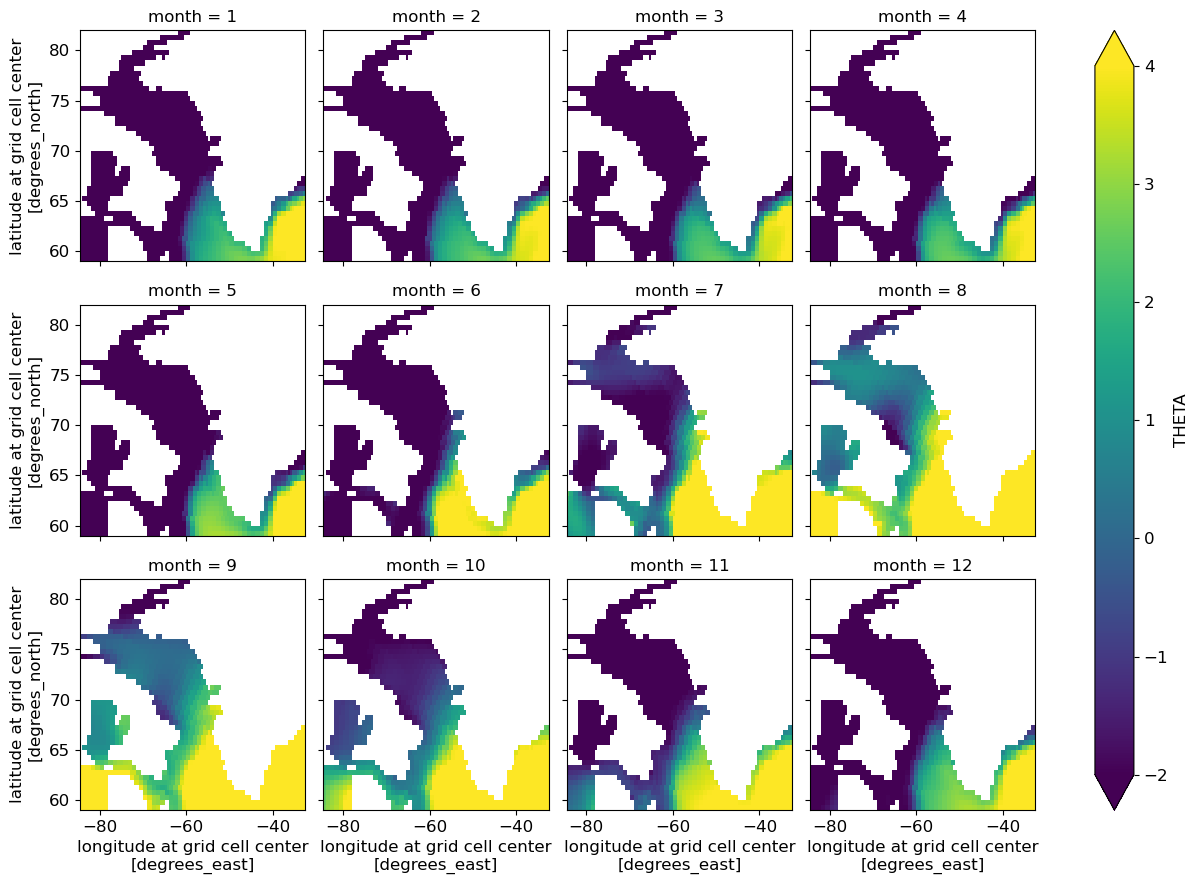

In [52]:
plt.rcParams['font.size'] = 12
temp_month_slice_ds.plot(x="longitude",y="latitude",vmin=-2,vmax=4,col="month",col_wrap=4)

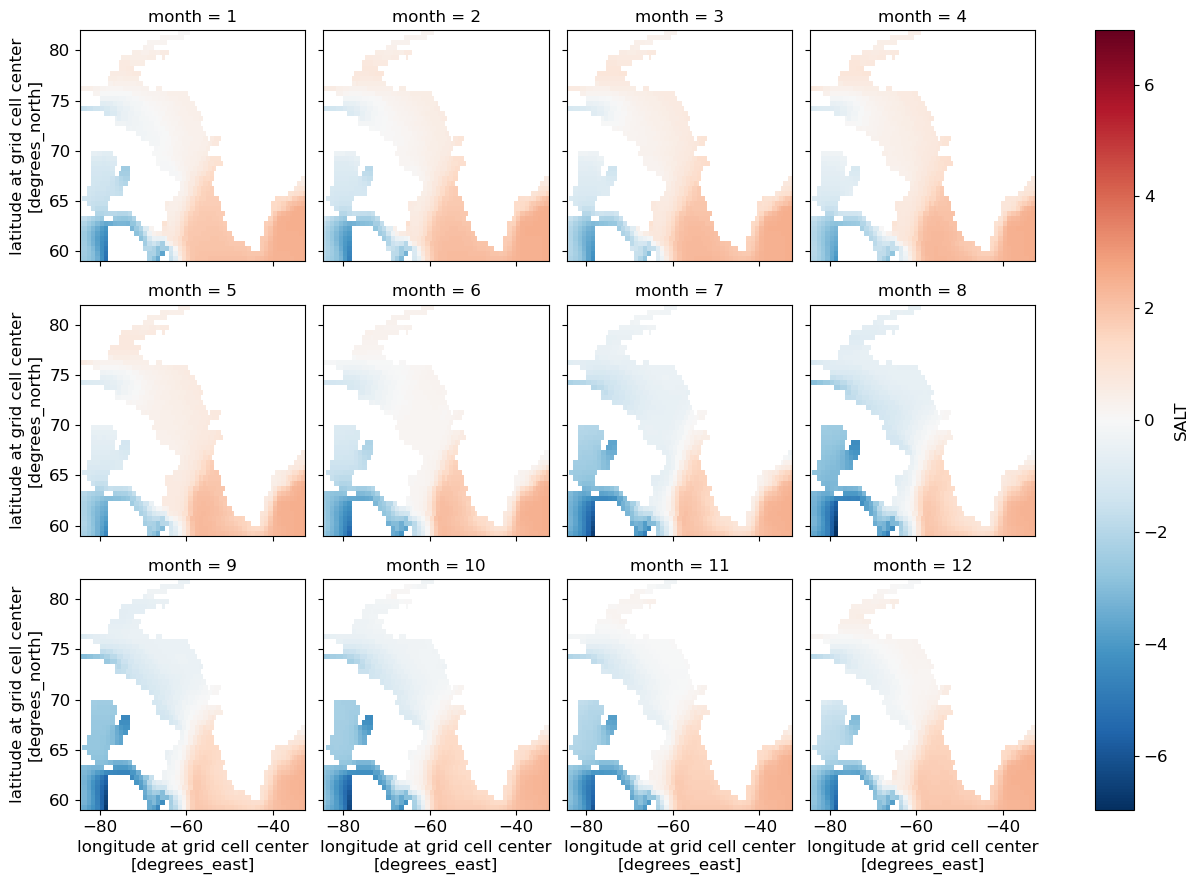

In [51]:
plt.rcParams['font.size'] = 12
salt_month_slice_ds.plot(x="longitude",y="latitude",col="month",col_wrap=4)

### Look at regions along continental shelf

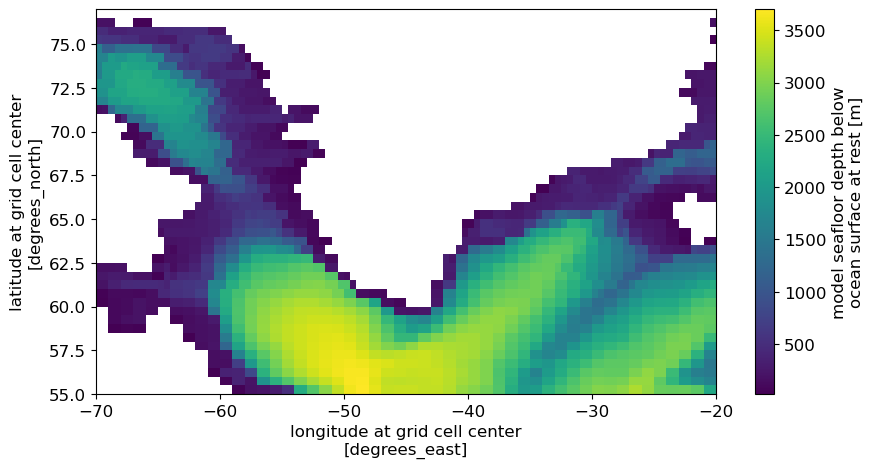

In [64]:
ecco_depth.sel(latitude=slice(55,77), longitude=slice(-70, -20)).plot();

In [71]:
# create masks for regions farther offshore (>2000 m deep) around Greenland

# SE Greenland
SE_greenland_mask = np.where(np.logical_and(ecco_depth > 100, ecco_depth < 1000), 1, np.nan)*\
                    np.where(np.logical_and(data_y_mg > 60, data_y_mg < 63), 1, np.nan)*\
                    np.where(data_x_mg > -43, 1, np.nan)*np.where(data_x_mg < -35, 1, np.nan)

# SW Greenland
SW_greenland_mask = np.where(np.logical_and(ecco_depth > 100, ecco_depth < 1000), 1, np.nan)*\
                    np.where(np.logical_and(data_y_mg > 60, data_y_mg < 63), 1, np.nan)*\
                    np.where(data_x_mg > -53, 1, np.nan)*np.where(data_x_mg < -50, 1, np.nan)

# # central W Greenland
# CW_greenland_mask = np.where(np.logical_and(ecco_depth > 2000, ecco_depth < 3000), 1, np.nan)*\
#                     np.where(np.logical_and(data_y_mg > 60, data_y_mg < 63), 1, np.nan)*\
#                     np.where(data_x_mg > -53, 1, np.nan)*np.where(data_x_mg < -50, 1, np.nan)

# NW Greenland
NW_greenland_mask = np.where(np.logical_and(ecco_depth > 100, ecco_depth < 1000), 1, np.nan)*\
                    np.where(np.logical_and(data_y_mg > 74, data_y_mg < 77), 1, np.nan)*\
                    np.where(data_x_mg > -65, 1, np.nan)*np.where(data_x_mg < -56, 1, np.nan)

In [72]:
# multiply ecco temp/salinity by mask to isolate data 
SE_greenland_temp_da = temp_salt_ds.THETA*SE_greenland_mask
SW_greenland_temp_da = temp_salt_ds.THETA*SW_greenland_mask
# CW_greenland_temp_da = temp_salt_ds.THETA*CW_greenland_mask
NW_greenland_temp_da = temp_salt_ds.THETA*NW_greenland_mask

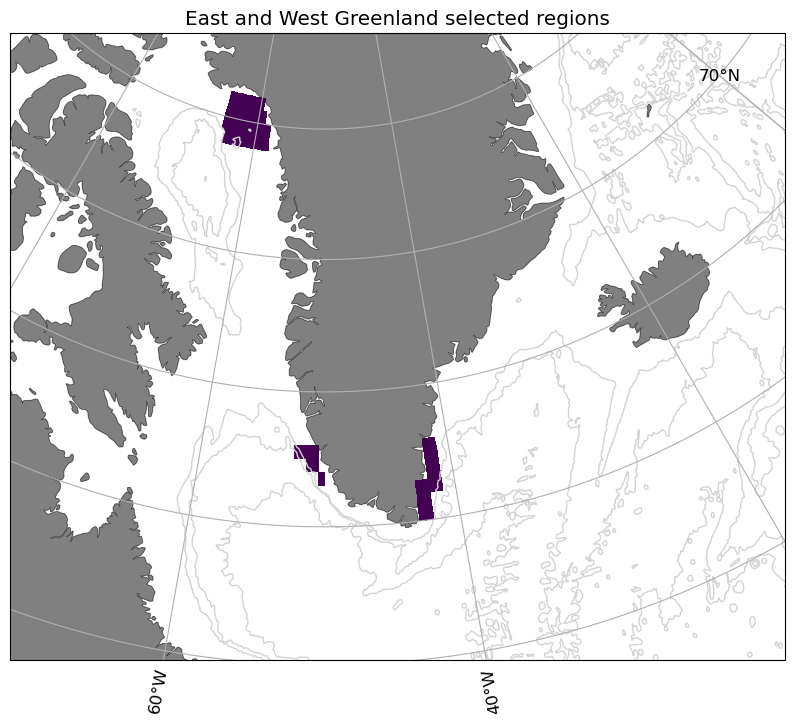

In [73]:
# Plot region selected for analysis
plt.rcParams['font.size'] = 12
fig = plt.figure(figsize=[10,10])

ax1=plt.subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude=-50))
ax1.set_extent([-70, -20, 55, 77], ccrs.PlateCarree()) # Limit the map extent
ax1.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=0.2)
ax1.add_feature(cfeature.LAND, color='gray')
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
ax1.add_feature(bathym, facecolor='none', edgecolor='lightgray')
bathym = cfeature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical')
ax1.add_feature(bathym, facecolor='none', edgecolor='lightgray')
bathym = cfeature.NaturalEarthFeature(name='bathymetry_H_3000', scale='10m', category='physical')
ax1.add_feature(bathym, facecolor='none', edgecolor='lightgray', label=True)

gl = ax1.gridlines(draw_labels=True)

gl.top_labels=False

data_cartopy_crs = ccrs.PlateCarree()
SE_greenland_temp_da.isel(time=10, Z=5).plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='viridis',vmin= 5, vmax=6,add_colorbar=False)
SW_greenland_temp_da.isel(time=10, Z=5).plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='viridis',vmin= 5, vmax=6,add_colorbar=False)
# CW_greenland_temp_da.isel(time=10, Z=5).plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='viridis',vmin= 5, vmax=6,add_colorbar=False)
NW_greenland_temp_da.isel(time=10, Z=5).plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='viridis',vmin= 5, vmax=6,add_colorbar=False)
                         
ax1.set_title("East and West Greenland selected regions");

Plot timeseries of temperature and salinity at 200m

In [74]:
# calculate the area-weighted mean
area_SE = geometry_ds.area*SE_greenland_mask
area_SE_total = area_SE.sum(['latitude','longitude'])

area_SW = geometry_ds.area*SW_greenland_mask
area_SW_total = area_SW.sum(['latitude','longitude'])

area_NW = geometry_ds.area*NW_greenland_mask
area_NW_total = area_NW.sum(['latitude','longitude'])

In [75]:
# temp weighted by grid-cell area
SE_temp_mean_weighted = (SE_greenland_temp_da*area_SE).sum(dim=["latitude","longitude"])/area_SE_total
SW_temp_mean_weighted = (SW_greenland_temp_da*area_SW).sum(dim=["latitude","longitude"])/area_SW_total
NW_temp_mean_weighted = (NW_greenland_temp_da*area_NW).sum(dim=["latitude","longitude"])/area_NW_total

# now get the mean for each month from 1992-2017
SE_temp_mean_month_weighted = SE_temp_mean_weighted.groupby("time.month").mean(dim=["time"])
SW_temp_mean_month_weighted = SW_temp_mean_weighted.groupby("time.month").mean(dim=["time"])
NW_temp_mean_month_weighted = NW_temp_mean_weighted.groupby("time.month").mean(dim=["time"])

In [97]:
# For comparison, calculate unweighted monthly average
SE_temp_mean_month_unweighted = SE_greenland_temp_da.groupby("time.month").mean(dim=['time','latitude','longitude'])
SW_temp_mean_month_unweighted = SW_greenland_temp_da.groupby("time.month").mean(dim=['time','latitude','longitude'])

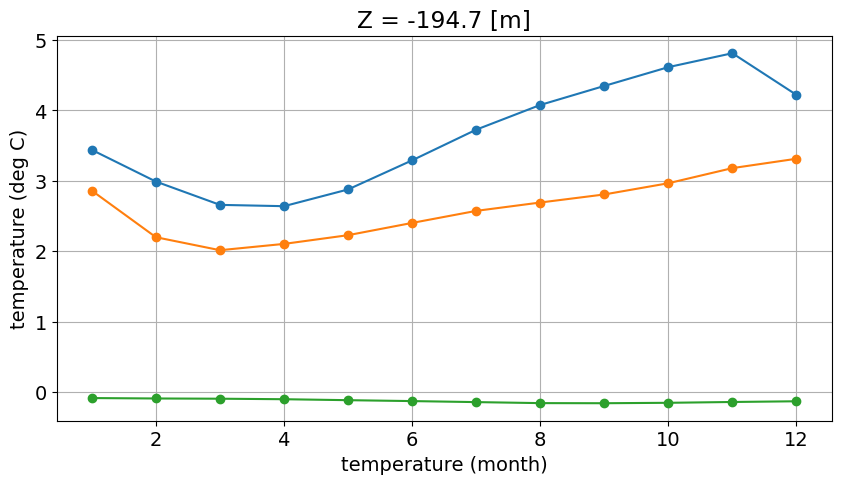

In [76]:
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['font.size'] = 14

SE_temp_mean_month_weighted.sel(Z=-200, method='nearest').plot(marker='o')
SW_temp_mean_month_weighted.sel(Z=-200, method='nearest').plot(marker='o')
NW_temp_mean_month_weighted.sel(Z=-200, method='nearest').plot(marker='o')

plt.grid()
plt.ylabel('temperature (deg C)')
plt.xlabel('temperature (month)');